### langgraph实现RAG

#### 初始化组件


In [1]:

import os
from pathlib import Path

os.chdir(Path().cwd())

print("%notebook:", os.getcwd())

%notebook: /media/gpt4-pdf-chatbot-langchain/langchain-ChatGLM/docs/solution


### Quickstart

#### Install Chatchat


In [2]:
!cd ../../libs/chatchat-server/ && rm -rf poetry.lock && poetry install --with lint,test -v

Using virtualenv: /media/gpt4-pdf-chatbot-langchain/pyenv-langchain
Updating dependencies
Resolving dependencies... (8.5s)Resolving dependencies... (2.0s)Resolving dependencies... (3.5s)Resolving dependencies... (6.7s)

Finding the necessary packages for the current system

Package operations: 0 installs, 0 updates, 0 removals, 205 skipped

  - Installing aiohttp (3.9.5): Pending...
  - Installing aiohttp (3.9.5): Skipped for the following reason: Already installed
  - Installing altair (4.2.2): Pending...
  - Installing altair (4.2.2): Skipped for the following reason: Already installed
  - Installing aiosignal (1.3.1): Pending...
  - Installing aiosignal (1.3.1): Skipped for the following reason: Already installed
  - Installing annotated-types (0.7.0): Pending...
  - Installing annotated-types (0.7.0): Skipped for the following reason: Already installed
  - Installing anyio (4.4.0): Pending...
  - Installing anyio (4.4.0): Skipped for the following reason: Already installed
  - Inst

#### CHATCHAT_ROOT用户工作空间
#### ZHIPUAI_API_KEY 开放平台key

In [3]:
import pandas as pd
import os
from pathlib import Path

api_key = os.environ.get("ZHIPUAI_API_KEY")

os.environ["CHATCHAT_ROOT"] = '/home/dmeck/chatchat-data'



#### 初始化用户空间

In [4]:
!rm -rf /home/dmeck/chatchat-data
!chatchat init

2024-07-23 18:19:52.608 | WARNING  | chatchat.server.utils:detect_xf_models:107 - cannot connect to xinference host: http://127.0.0.1:9997, please check your configuration.
2024-07-23 18:19:52.609 | WARNING  | chatchat.server.utils:get_default_llm:205 - default llm model glm4-chat is not found in available llms, using qwen:7b instead
2024-07-23 18:19:52.616 | WARNING  | chatchat.server.utils:get_default_embedding:214 - default embedding model bge-m3 is not found in available embeddings, using quentinz/bge-large-zh-v1.5 instead
2024-07-23 18:19:52.617 | WARNING  | chatchat.server.utils:get_default_embedding:214 - default embedding model bge-m3 is not found in available embeddings, using quentinz/bge-large-zh-v1.5 instead
2024-07-23 18:19:52.618 | WARNING  | chatchat.server.utils:get_default_embedding:214 - default embedding model bge-m3 is not found in available embeddings, using quentinz/bge-large-zh-v1.5 instead
2024-07-23 18:19:52.620 | WARNING  | chatchat.server.utils:get_default_em

### 设置工作空间使用的模型与embedding
确保所有配置正确后（特别是 LLM 和 Embedding Model），执行下列命令创建默认知识库、启动服务：


In [5]:
import pandas as pd
import os
from pathlib import Path
 

model_settings_YAML = f"""
# 模型配置项


# 默认选用的 LLM 名称
DEFAULT_LLM_MODEL: glm-4

# 默认选用的 Embedding 名称
DEFAULT_EMBEDDING_MODEL: embedding-2

# AgentLM模型的名称 (可以不指定，指定之后就锁定进入Agent之后的Chain的模型，不指定就是 DEFAULT_LLM_MODEL)
Agent_MODEL: ''

# 默认历史对话轮数
HISTORY_LEN: 3

# 大模型最长支持的长度，如果不填写，则使用模型默认的最大长度，如果填写，则为用户设定的最大长度
MAX_TOKENS:

# LLM通用对话参数
TEMPERATURE: 0.7
 
SUPPORT_AGENT_MODELS:
  - chatglm3-6b
  - glm-4
  - openai-api
  - Qwen-2
  - qwen2-instruct
  - gpt-3.5-turbo
  - gpt-4o
 
LLM_MODEL_CONFIG:
  preprocess_model:
    model: ''
    temperature: 0.05
    max_tokens: 4096
    history_len: 10
    prompt_name: default
    callbacks: false
  llm_model:
    model: ''
    temperature: 0.9
    max_tokens: 4096
    history_len: 10
    prompt_name: default
    callbacks: true
  action_model:
    model: ''
    temperature: 0.01
    max_tokens: 4096
    history_len: 10
    prompt_name: ChatGLM3
    callbacks: true
  postprocess_model:
    model: ''
    temperature: 0.01
    max_tokens: 4096
    history_len: 10
    prompt_name: default
    callbacks: true
  image_model:
    model: sd-turbo
    size: 256*256

# # 模型加载平台配置

 
MODEL_PLATFORMS:
  - platform_name: zhipuai
    platform_type: custom openai
    api_base_url: https://open.bigmodel.cn/api/paas/v4
    api_key: {api_key}
    api_proxy: ''
    api_concurrencies: 5
    auto_detect_model: false
    llm_models: [
        "glm-4"
    ]
    embed_models: [
        "embedding-2"
    ]
    text2image_models: []
    image2text_models: []
    rerank_models: []
    speech2text_models: []
    text2speech_models: []
 
"""

model_settings_file =  Path(f"{os.environ.get('CHATCHAT_ROOT')}/model_settings.yaml")
with model_settings_file.open("w") as file:
    file.write(model_settings_YAML)
model_settings_file


PosixPath('/home/dmeck/chatchat-data/model_settings.yaml')

In [6]:
!chatchat kb -r

recreating all vector stores
2024-07-23 18:20:02.514 | INFO     | chatchat.server.knowledge_base.kb_cache.faiss_cache:load_vector_store:109 - loading vector store in 'samples/vector_store/embedding-2' from disk.
2024-07-23 18:20:02.913 | INFO     | chatchat.server.knowledge_base.kb_cache.faiss_cache:load_vector_store:109 - loading vector store in 'samples/vector_store/embedding-2' from disk.
2024-07-23 18:20:03.190 | INFO     | chatchat.server.knowledge_base.utils:file2docs:336 - TextLoader used for /home/dmeck/chatchat-data/data/knowledge_base/samples/content/大模型技术栈-实战与应用.md
文档切分示例：page_content='# 大模型技术栈-实战与应用
- 训练框架
    - deepspeed
    - megatron-lm
    - colossal-ai
    - trlx
- 推理框架
    - triton
    - vllm
    - text-generation-inference
    - lit-llama
    - lightllm
    - TensorRT-LLM(原FasterTransformer)
    - fastllm
    - inferllm
    - llama-cpp
    - openPPL-LLM
- 压缩框架
    - bitsandbytes
    - auto-gptq
    - deepspeed
- embedding框架
    - sentence-transformer
    - FlagEmbedd

#### 安装langgraph

In [7]:
!pip install langgraph

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


#### 使用chatchat提供的组件构建检索图

LangGraph 因其高度可控的代理框架而闻名。下面示例演示了，利用chatchat封装的组件，如何实现这种可控性。
 https://langchain-ai.github.io/langgraph/how-tos/

In [8]:
from __future__ import annotations

import asyncio
from chatchat.settings import Settings
from chatchat.server.agent.tools_factory.tools_registry import (
    BaseToolOutput,
    regist_tool,
    format_context,
)
from chatchat.server.agent.tools_factory.search_internet import search_engine
from chatchat.server.knowledge_base.kb_api import list_kbs
from chatchat.server.knowledge_base.kb_doc_api import search_docs
from chatchat.server.pydantic_v1 import Field
from chatchat.server.utils import get_tool_config

from typing import Dict, List
from typing_extensions import TypedDict
from langchain.prompts.prompt import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from chatchat.server.utils import (
    get_prompt_template,
)
import rich

from chatchat.server.utils import get_ChatOpenAI
from langchain_core.pydantic_v1 import BaseModel
from langchain import globals



#### 一些基础的状态信息 https://langchain-ai.github.io/langgraph/concepts/low_leve

- StateGraph 类是要使用的主要图形类。这是由用户定义的 State 对象参数化的。
- State ：表示应用程序当前快照的共享数据结构。它可以是任何 Python 类型，但通常是 TypedDict 或 Pydantic BaseModel 。
- Nodes ：对代理逻辑进行编码的 Python 函数。它们接收当前的 State 作为输入，执行一些计算或副作用，并返回更新的 State 。
- Edges ：Python 函数，根据当前的 State 确定接下来要执行哪个 Node 。它们可以是条件分支或固定转换。


In [9]:


# globals.set_debug(True)


template = (
    "Use local knowledgebase from one or more of these:\n{KB_info}\n to get information，Only local data on "
    "this knowledge use this tool. The 'database' should be one of the above [{key}]."
)
KB_info_str = "\n".join(
    [f"{key}: {value}" for key, value in Settings.kb_settings.KB_INFO.items()])
template_knowledge = template.format(KB_info=KB_info_str, key="samples")

# Data model


class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )
# Data model


class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )
# Data model


class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    knowledge_base: str
    top_k: int
    score_threshold: float
    generation: str
    docs: List[Dict]
    retrieve_retry: int


#### 节点中使用的llm

In [32]:

model_name = "glm-4"
llm = get_ChatOpenAI(
    model_name=model_name,
    temperature=0.1,
    max_tokens=4096,
    streaming=True,
    local_wrap=False,
    # verbose=True,
)

#### 创建一个retrieve检索
这里的search_docs会通过langchain的embdding组件获取召回的向量，依据向量检索矢量库，获取到分片数据

#### 默认faiss 向量库/全文检索引擎类型 
 可选值：['faiss', 'milvus', 'zilliz', 'pg', 'es', 'relyt', 'chromadb']



In [10]:

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    database = state["knowledge_base"]
    top_k = state["top_k"]
    score_threshold = state["score_threshold"]

    # Retrieval
    docs = search_docs(
        query=question,
        knowledge_base_name=database,
        top_k=top_k,
        score_threshold=score_threshold,
        file_name="",
        metadata={},
    )
    return {"knowledge_base": database, "docs": docs, "question": question}



#### 这个节点采用LLM的能力来对文档数据过滤的，筛选出大致的相关数据

In [11]:

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    docs = state["docs"]

    # Prompt
    system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        Response in json format. here are some examples:
        - ```json\n{{"binary_score": "yes"}}```
        - ```json\n{{"binary_score": "no"}}```
        """
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human",
             "Retrieved document: \n\n {document} \n\n User question: {question}"),
        ]
    )

    structured_llm_grader = llm.with_structured_output(GradeDocuments, method="json_mode")

    retrieval_grader = grade_prompt | structured_llm_grader

    # Score each doc
    filtered_docs = []
    for d in docs:
        score = retrieval_grader.invoke(
            {"question": question, "document": d["page_content"]}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    if state["retrieve_retry"] <= 1:
        filtered_docs = []
    return {"docs": filtered_docs, "question": question}



#### 对召回结果加入上下文，发起问答生成一个generation

In [12]:

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    docs = state["docs"]

    prompt_template = PromptTemplate.from_template(
        get_prompt_template("rag", "default"), template_format="jinja2"
    )
    rag_chain = prompt_template | llm | StrOutputParser()
    # RAG generation
    context = "\n\n".join([f"[{i+1}] {x['page_content']}" for i,x in enumerate(docs)])
    generation = rag_chain.invoke({"context": context, "question": question})
    return {"docs": docs, "question": question, "generation": generation}



#### 问题改写.使用llm的能力进行改写

In [13]:

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    docs = state["docs"]

    # Prompt
    system = """You are a question re-writer that converts an input question to a better version that is optimized \n 
        for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning.
        Respond in Chinese."""
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )
    question_rewriter = re_write_prompt | llm | StrOutputParser()
    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    # better_question = "介绍一下chatchat"
    return {"docs": docs, "question": better_question, "retrieve_retry": 1}



#### 理由chatchat定义的工具联网查询信息


In [14]:

def search_internet(state):
    """
    search documents from internet
    """
    print("---Search Internet---")
    question = state["question"]
    top_k = state["top_k"]
    docs = search_engine(question, top_k)

    return {"docs": [x.dict() for x in docs["docs"]], "retrieve_retry": 2}


#### 一些条件状态
处理召回结果，没有内容使用互联网

In [24]:

def retry_search_internet(state):
    if not state["docs"]:
        return "search_internet"
    return "grade_documents"

#### 对问题进行评估
简单的判断是否进行问题改写

In [16]:


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    filtered_documents = state["docs"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        if state["retrieve_retry"] == 0:
            return "transform_query"
        else:
            return "search_internet"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


#### 条件节点，模型对问题和答案进行评估
由条件边跳转至问题改写节点

In [21]:

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    docs = state["docs"]
    generation = state["generation"]

    structured_llm_grader = llm.with_structured_output(GradeHallucinations, method="json_mode")

    # Prompt
    system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
        Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts.
        Response in json format. here are some examples:
        - ```json\n{{"binary_score": "yes"}}```
        - ```json\n{{"binary_score": "no"}}```
        """
    hallucination_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human",
             "Set of facts: \n\n {docs} \n\n LLM generation: {generation}"),
        ]
    )

    hallucination_grader = hallucination_prompt | structured_llm_grader
    score = hallucination_grader.invoke(
        {"docs": docs, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Prompt
        system = """You are a grader assessing whether an answer addresses / resolves a question \n 
            Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question.
            Response in json format. here are some examples:
            - ```json\n{{"binary_score": "yes"}}```
            - ```json\n{{"binary_score": "no"}}```
            """
        answer_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                ("human",
                 "User question: \n\n {question} \n\n LLM generation: {generation}"),
            ]
        )
        structured_llm_grader = llm.with_structured_output(GradeAnswer, method="json_mode")
        answer_grader = answer_prompt | structured_llm_grader
        score = answer_grader.invoke(
            {"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"



### 现在构造运行图
要构建图，首先定义状态，然后添加节点和边，最后编译它。到底是什么在编译你的图表以及为什么需要它？
编译是一个非常简单的步骤。它提供了对图形结构的一些基本检查（没有孤立节点等）。
您还可以在其中指定运行时参数，例如检查点和断点。您只需调用 .compile 方法即可编译图表：

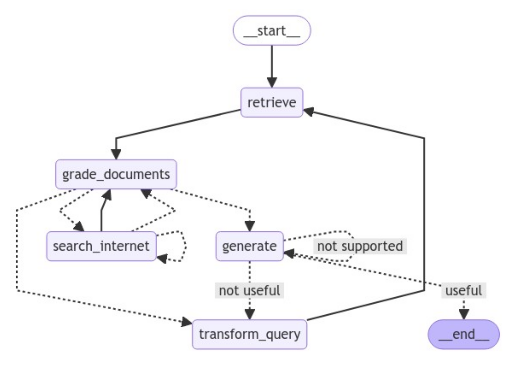

In [33]:


from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("search_internet", search_internet)

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("search_internet", "grade_documents")
workflow.add_conditional_edges(
    "search_internet",
    retry_search_internet,
    {
        "search_internet": "search_internet",
        "grade_documents": "grade_documents",
    }
    )

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "search_internet": "search_internet",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)
# Compile
app = workflow.compile()
g = app.get_graph() 



import matplotlib.pyplot as plt
from PIL import Image

import io

mermaid_png_data = g.draw_mermaid_png()
image = Image.open(io.BytesIO(mermaid_png_data))

plt.imshow(image)
plt.axis('off')  # 去掉坐标轴
plt.show()

#### 启动这个检索图

In [35]:
from langchain_core.messages import HumanMessage
import sys
sys.setrecursionlimit(1000)  # You can set this to a higher value if needed


query: str = "介绍一下chatchat"
database: str="samples" 
config = get_tool_config("search_local_knowledgebase")
 
inputs = {"question": query, "knowledge_base": database, "retrieve_retry": 0,
          "top_k": config["top_k"], "score_threshold": config["score_threshold"],}

# async for e in app.astream_events(inputs, version="v2"):
#     rich.print('\n\n')
#     rich.print(e)

# Final generation
# print(value["generation"])
response = app.invoke(inputs)
rich.print(response)

---RETRIEVE---


/media/gpt4-pdf-chatbot-langchain/pyenv-langchain/lib/python3.10/site-packages/langchain_core/vectorstores/base.py:796: UserWarning: No relevant docs were retrieved using the relevance score threshold 2.0
  warnings.warn(


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---RETRIEVE---


/media/gpt4-pdf-chatbot-langchain/pyenv-langchain/lib/python3.10/site-packages/langchain_core/vectorstores/base.py:796: UserWarning: No relevant docs were retrieved using the relevance score threshold 2.0
  warnings.warn(


---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---Search Internet---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{
    'question': '请详细说明Chatchat的特点和用途是什么？',
    'knowledge_base': 'samples',
    'top_k': 3,
    'score_threshold': 2.0,
    'generation': 
'Chatchat的特点主要包括以下几点：首先，它是一款基于自然语言处理技术的智能问答系统；其次，它采用了先进的深度学习算法
和大规模语料库训练，能够理解用户的意图和问题，并给出相应的回答和建议。\n\nChatchat的用途主要是帮助用户快速准确地获
取所需信息。通过自然语言交互，用户可以提出问题，系统则会根据问题内容提供相应的回答和建议，从而提高信息获取效率。',
    'docs': [
        {
            'id': None,
            'metadata': {
                'source': 'https://developer.baidu.com/article/details/3237941',
                'filename': '掌握大模型工具：Langchain-Chatchat的实践与应用-百度开发者中心'
            },
            'page_content': '一、基本概念. 
Langchain-Chatchat是一款基于自然语言处理技术的智能问答系统，它可以帮助用户快速准确地获取所需信息。. 
该系统采用了先进的 深度学习 算法和大规模语料库训练，使得它能够理解用户的意图和问题，并给出相应的回答和建议。. 
二、特点. 自然 ...',
            'type': 'Document'
        }
    ],
    'retrieve_retry': 2
}